<a href="https://www.kaggle.com/code/maicmi/exceptional-bitcoin-prediction-with-tensorflow?scriptVersionId=135080370" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exceptional Bitcoin Prediction with TensorFlow

⚠️ Be Aware!!! This is not financial advice.<br>
⚠️ Risky investments, investors should study the information before making a decision to invest

> "What will the price of Bitcoin be tomorrow?"

Fundamental analysis occurs when a potential investor attempts to determine the real value of an asset. This is done by using all publicly available information about the asset to assess how financially rewarding it will be to own. News about the asset or the economy will reshape fundamental analysis-based estimates.

Investors assume that an asset will gravitate towards its fair market value over time, so if the result of the fundamental analysis is different from the current market price, then there is a trading opportunity. Good fundamental analysis allows investors to buy assets that are undervalued and sell those that are overvalued.

Technical analysis differs from fundamental analysis, in that traders look to statistical trends in the bitcoin's price and volume. Both methods (fundamental and technical analysis) are used for researching and forecasting future trends in bitcoin prices.

What is in this time series analysis?
* Downloading and formatting time series data (Yahoo finance)
* Writing a preprocessing function to prepare the time series data
* Setting up multiple time series modeling
    > * Naïve Forecasting
    > * Dense Model
    > * LSTM Model
    > * Future Prediction Model
* Building a multivariate model to take in multivariate time series data
* Making forecasts with prediction intervals

In [1]:
from IPython.core.display import HTML
from IPython.display import display, Markdown
HTML("""
<style>
@import url("https://fonts.googleapis.com/css2?family=Raleway&family=Roboto:ital,wght@0,500;0,900;1,500&display=swap");
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    display: inline-block;
    text-align: center;
    padding: 30px;
    margin: 0;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;
    font-family: Raleway;
    border-radius: 5px;
}

h2 {
    display: inline-block;
    text-align: center;
    padding: 25px;
    margin: 0;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;
    font-family: Raleway;
    border-radius: 5px;
}

h3 {
    display: inline-block;
    text-align: center;
    padding: 20px;
    margin: 0;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;
    font-family: Raleway;
    border-radius: 5px;
}


body, p, ul, li {
    font-family: Raleway;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: Raleway;
    font-size: 20px;
    background: linear-gradient(to right, #30CFD0 0%, #121FCF 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
}
</style>
""")

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.9 MB/s eta 0:00:00


In [3]:
# import package
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import IPython.display
from IPython.display import display, Markdown, clear_output

import plotly.graph_objects as go
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Prepare Bitcoin data for analysis

In [4]:
ticker = yf.Ticker('BTC-USD')
btc = ticker.history(period="max")
btc.head()

timesteps = btc.index.to_numpy()
prices = btc["Close"].to_numpy()

timesteps[:10],prices[:10]

(array([Timestamp('2014-09-17 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-18 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-19 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-20 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-21 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-22 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-23 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-24 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-25 00:00:00+0000', tz='UTC'),
        Timestamp('2014-09-26 00:00:00+0000', tz='UTC')], dtype=object),
 array([457.33401489, 424.44000244, 394.79598999, 408.9039917 ,
        398.8210144 , 402.15200806, 435.79098511, 423.20498657,
        411.57400513, 404.42498779]))

# Create train and test sets of time series data

In [5]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test 

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2564, 641, 2564, 641)

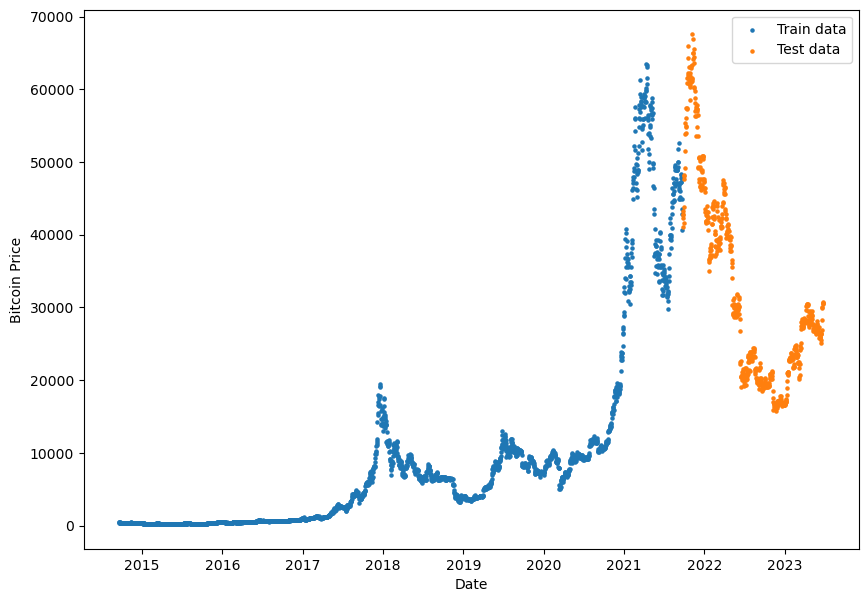

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

# 1. What is Naïve Forecasting
Naïve forecasting is one of the simplest demand forecasting methods often used by sales and finance departments. It uses the actual observed sales from the last period as the forecast for the next period, without considering any predictions or factor adjustments. Though simple, it can work remarkably well for business. But it doesn’t account for the changing market conditions or seasonality, factors that can substantially affect demand. 

In [7]:
# Naïve forecasting model
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([42839.75      , 42716.59375   , 43208.5390625 , 42235.73046875,
        41034.54296875, 41564.36328125, 43790.89453125, 48116.94140625,
        47711.48828125, 48199.953125  ]),
 array([26327.46289062, 26510.67578125, 26336.21289062, 26851.02929688,
        28327.48828125, 30027.296875  , 29912.28125   , 30695.46875   ,
        30548.6953125 , 30480.26171875]))

In [8]:
y_test[-10:]

array([26510.67578125, 26336.21289062, 26851.02929688, 28327.48828125,
       30027.296875  , 29912.28125   , 30695.46875   , 30548.6953125 ,
       30480.26171875, 30637.60546875])

In [9]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):

    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price")
    if label:
        plt.legend(fontsize=15)
    plt.grid(True)

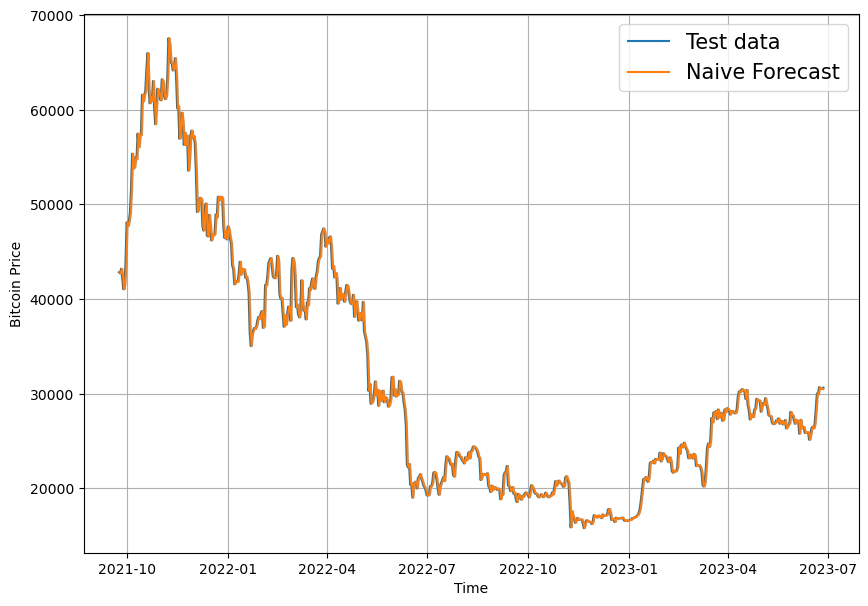

In [10]:
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test, values=y_test, start=0, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=0, format="-", label="Naive Forecast") #Offset X_test -> [1:] from index 1

# Evaluating a time series model

Performance estimation aims at estimating the loss that a predictive model will incur on unseen data. This process is a fundamental stage in any machine learning project.

* Mean absolute error (MAE) 
    - As a greate starter metric for any regression problem.
* Mean square error (MSE)
    - When larger erros are more significant than smaller errors.
* Root mean squared error (RMSE)
    - Smimilar to MSE but as interpretable as MAE (RMSE is in same units as target).
* (symmetric) Mean absolute percentage error (MAPE/sMAPE)
    - Recommend not to use by Hyndman & Koehler.
* Mean absolute scaled error (MASE)
    - A scaled error is >1 if the forecast is worse than the Naïve and <1 if the forecast is better than the Naïve.

In [11]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    # MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    
    return mae / mae_naive_no_season

In [12]:
# Create a function for evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    # longer horizon
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [13]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 706.88025,
 'mse': 1191483.5,
 'rmse': 1091.5509,
 'mape': 2.166819,
 'mase': 0.9987095}

# 2. Dense model
**(window = 7, horizon = 1)**

**Format data using Windowing the dataset**

We turn our data into window size

Horizon = number of timesteps into the future we're going to predict
Window size = number of timesteps we're going to use to predict horizon

Example:
Horizon = 1, window = 7
Predict the next day price, given 7 days window size.

In [14]:
print(f"We are going to use: {prices[:7]} to predict: {prices[7]}")

We are going to use: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511] to predict: 423.2049865722656


In [15]:
# Setup global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of AAPL price

In [16]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


## Next Question
> Can we predict the price of Bitcoin tomorrow give the past week of prices?

## Preprocessing function

There is a function for preprocessing -> tf.keras.preprocessing.timeseries_dataset_from_arry. Anyway, below custom function could let us know how preprocessing can turn the problem into supervised.


In [18]:
# Create function to view numpy array as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    # 1. Create a window of specific window_size
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # 2. Create 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    # print(f"Window indexes: \n {window_indexes, window_indexes.shape}")
    
    # 3. Index on the target array with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)
    
    # 4. Get the label windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [19]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3198, 3198)

In [20]:
for i in range(3): 
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511] -> Label: [423.20498657]
Window: [424.44000244 394.79598999 408.9039917  398.8210144  402.15200806
 435.79098511 423.20498657] -> Label: [411.57400513]
Window: [394.79598999 408.9039917  398.8210144  402.15200806 435.79098511
 423.20498657 411.57400513] -> Label: [404.42498779]


In [21]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [22]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2558, 640, 2558, 640)

In [23]:
test_windows[:5]

array([[48278.36328125, 47260.21875   , 42843.80078125, 40693.67578125,
        43574.5078125 , 44895.09765625, 42839.75      ],
       [47260.21875   , 42843.80078125, 40693.67578125, 43574.5078125 ,
        44895.09765625, 42839.75      , 42716.59375   ],
       [42843.80078125, 40693.67578125, 43574.5078125 , 44895.09765625,
        42839.75      , 42716.59375   , 43208.5390625 ],
       [40693.67578125, 43574.5078125 , 44895.09765625, 42839.75      ,
        42716.59375   , 43208.5390625 , 42235.73046875],
       [43574.5078125 , 44895.09765625, 42839.75      , 42716.59375   ,
        43208.5390625 , 42235.73046875, 41034.54296875]])

## Make a modeling checkpoint
Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More speificially, we want to compare each of our model's best performance against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [24]:
# Create a function to implement a ModelCheckpoint
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor="val_loss",
                                              verbose=0, # only output a limited amount of text
                                              save_best_only=True)

## Create Dense Model
We have 7 days to predict 1 day

- A single dense layer with 128 hidden units - ReLu
- An output layer with linear activation
- Adam optimization and MAE loss function
- Batch size of 128 (previously we've used 32)
- 100 epochs

In [25]:
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# 1. Create a model
dense_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="dense_model_saved")

# 2. Compile the model
dense_model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

# 3. Fit the model
dense_model.fit(x=train_windows,
                y=train_labels,
                epochs=100,
                verbose=0,
                batch_size=128,
                validation_data=(test_windows, test_labels),
                callbacks=[create_model_checkpoint(model_name=dense_model.name)])

In [26]:
# Evaluate the model
dense_model.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 725.1558 - mae: 725.1558 - mse: 1246459.7500


[725.15576171875, 725.15576171875, 1246459.75]

In [27]:
# load the saved best performance
dense_model = tf.keras.models.load_model("model_experiments/dense_model_saved/")
dense_model.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 724.3046 - mae: 724.3046 - mse: 1248191.0000


[724.3046264648438, 724.3046264648438, 1248191.0]

In [28]:
# Make the forecasts with a model 
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return ID array of predictions

In [29]:
dense_model_preds = make_preds(dense_model, test_windows)
len(dense_model_preds), dense_model_preds[:10]

20/20 [==============================] - 0s 2ms/step


(640,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([43138.527, 42659.992, 42894.906, 42320.367, 41368.145, 41326.94 ,
        43330.81 , 47443.344, 47942.13 , 48252.6  ], dtype=float32)>)

In [30]:
# let's see test labels
test_labels[:10]

array([[42716.59375   ],
       [43208.5390625 ],
       [42235.73046875],
       [41034.54296875],
       [41564.36328125],
       [43790.89453125],
       [48116.94140625],
       [47711.48828125],
       [48199.953125  ],
       [49112.90234375]])

In [31]:
# Evaluate the preds
dense_model_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                     y_pred=dense_model_preds)
dense_model_results

{'mae': 724.3047,
 'mse': 1248190.8,
 'rmse': 1117.2245,
 'mape': 2.2227929,
 'mase': 1.0233275}

In [32]:
# base line
naive_results

{'mae': 706.88025,
 'mse': 1191483.5,
 'rmse': 1091.5509,
 'mape': 2.166819,
 'mase': 0.9987095}

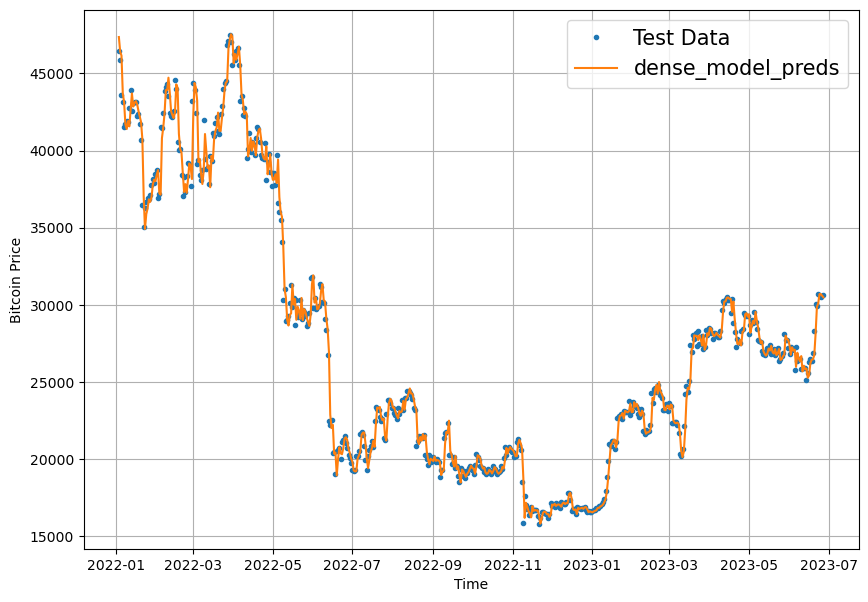

In [33]:
# Plot dense_model predictions
offset = 100
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                      values=test_labels[:, 0],
                      start=offset,
                      label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                      values=dense_model_preds,
                      start=offset,
                      format="-",
                      label="dense_model_preds")

# 3. LSTM Model
> What is LSTM?

LSTM is a Recurrent Neural Network that works on data sequences, learning to retain only relevant information from a time window. New information the network learns is added to a “memory” that gets updated with each timestep based on how significant the new sample seems to the model. Over the years, LSTM has revolutionized speech and handwriting recognition, language understanding, forecasting, and several other applications that have become the new normal today. 


In [34]:
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)


# build an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
lstm_model = tf.keras.Model(inputs=inputs, outputs=output, name="lstm_model_saved")

# Compile the model
lstm_model.compile(loss="mae",
                   optimizer=tf.keras.optimizers.Adam())

# Fit the model
lstm_model.fit(train_windows,
              train_labels,
              epochs=100,
              verbose=0,
              batch_size=128,
              validation_data=(test_windows, test_labels),
              callbacks=[create_model_checkpoint(model_name=lstm_model.name)])

In [35]:
# Load in best version of lstm model
lstm_model = tf.keras.models.load_model("model_experiments/lstm_model_saved")
lstm_model.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 753.1686


753.1685791015625

In [36]:
# Make predictions with our LSTM model
lstm_model_preds = make_preds(lstm_model, test_windows)
lstm_model_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([43347.723, 43122.07 , 43040.715, 42273.652, 41288.96 ],
      dtype=float32)>

In [37]:
# Evaluate predictions
lstm_model_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                    y_pred=lstm_model_preds)
lstm_model_results

{'mae': 753.1686,
 'mse': 1338027.6,
 'rmse': 1156.7314,
 'mape': 2.3117013,
 'mase': 1.0641075}

# 4. Future Prediction Model

## Make a multivariate time series dataset

One of the most pivotal events on Bitcoin's blockchain is a halving, when the reward for mining is cut in half. As of 2023, network participants who validate transactions are awarded 6.25 bitcoins (BTC) for each block successfully mined.

The next halving is expected to occur in April or May 2024, when the block reward will fall to 3.125. Over time, the impact of each halving will diminish as the block reward approaches zero.

In [38]:
# Get Bitcoin Data
ticker = yf.Ticker('BTC-USD')
bitcoin = ticker.history(period="max")
bitcoin_prices = pd.DataFrame(bitcoin["Close"])

# Remove timezone
bitcoin_prices.index = pd.to_datetime(bitcoin.index.date)
bitcoin_prices.head()

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [39]:
# Bitcoin halving
# Historical bitcoin halving dates
# https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [40]:
# Create date range of where specific block_reward values reside
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
# from 9 July 2016 back to index
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days

(661, 2070)

In [41]:
# Add a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

## Making a windowed dataset with pandas

Previously, I've turned my univariate time series into windows but now I have got multivariate data, I have to use pandas.DataFrame.shift() to window multivariate data.

In [42]:
HORIZON = 1
WINDOW_SIZE = 7

In [43]:
# Copy the bitcoin historical data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed column
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
bitcoin_prices_windowed.head(20)

,Close,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990


In [44]:
# Create windows and horizon features (X, y)
X = bitcoin_prices_windowed.dropna().drop("Close", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Close"].astype(np.float32)
X.head()

,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [45]:
# Copy the bitcoin historical data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed column
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
bitcoin_prices_windowed.head(20)

,Close,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990


In [46]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Close", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Close"].to_numpy()

len(X_all), len(y_all)

(3198, 3198)

In [47]:
# Trun data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [48]:
tf.random.set_seed(42)

# Create a model
future_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="future_model")
# Compile the model
future_model.compile(loss=tf.keras.losses.mae,
                     optimizer=tf.keras.optimizers.Adam())

# Fit model
future_model.fit(dataset_all,
                 epochs=100,
                 verbose=0,
                 callbacks=[create_model_checkpoint(model_name=future_model.name)])

In [49]:
# Make predictions into future

# Timestep to predict into the future
INTO_FUTURE = 14

In [50]:
# Create function to make prediction into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]
    
    for _ in range(INTO_FUTURE):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
        
        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
        
        # Update last window with new pred
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
        
    return future_forecast

In [51]:
future_forecast = make_future_forecasts(values=y_all,
                                       model=future_model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 53ms/step
Predicting on:
 [28327.48828125 30027.296875   29912.28125    30695.46875
 30548.6953125  30480.26171875 30655.9140625 ] -> Prediction: 28895.24609375

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [30027.296875   29912.28125    30695.46875    30548.6953125
 30480.26171875 30655.9140625  28895.24609375] -> Prediction: 30159.75390625

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [29912.28125    30695.46875    30548.6953125  30480.26171875
 30655.9140625  28895.24609375 30159.75390625] -> Prediction: 30166.91015625

1/1 [==============================] - 0s 20ms/step
Predicting on:
 [30695.46875    30548.6953125  30480.26171875 30655.9140625
 28895.24609375 30159.75390625 30166.91015625] -> Prediction: 30444.5625

1/1 [==============================] - 0s 22ms/step
Predicting on:
 [30548.6953125  30480.26171875 30655.9140625  28895.24609375
 30159.75390625 30166.91015625 30444.5625    ] -> Pr

In [52]:
def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + np.timedelta64(offset, "D") # specify start date
    end_date = start_date + np.timedelta64(into_future, "D")
    return np.arange(start_date, end_date, dtype="datetime64[D]")

In [53]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timesteps = bitcoin_prices.index[-1]
last_timesteps

Timestamp('2023-06-27 00:00:00')

In [54]:
# Get next 2 weeks
next_time_steps = get_future_dates(start_date=last_timesteps,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01',
       '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05',
       '2023-07-06', '2023-07-07', '2023-07-08', '2023-07-09',
       '2023-07-10', '2023-07-11'], dtype='datetime64[D]')

In [55]:
# Insert last timesteps to join the line plot
next_time_steps = np.insert(next_time_steps, 0, last_timesteps)
future_forecast = np.insert(future_forecast, 0, bitcoin_prices["Close"][-1])
next_time_steps, future_forecast

(array(['2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
        '2023-07-01', '2023-07-02', '2023-07-03', '2023-07-04',
        '2023-07-05', '2023-07-06', '2023-07-07', '2023-07-08',
        '2023-07-09', '2023-07-10', '2023-07-11'], dtype='datetime64[D]'),
 array([30655.914, 28895.246, 30159.754, 30166.91 , 30444.562, 30431.52 ,
        29991.54 , 30051.043, 29359.543, 30173.89 , 30181.816, 30176.3  ,
        30122.998, 29724.367, 29834.96 ], dtype=float32))

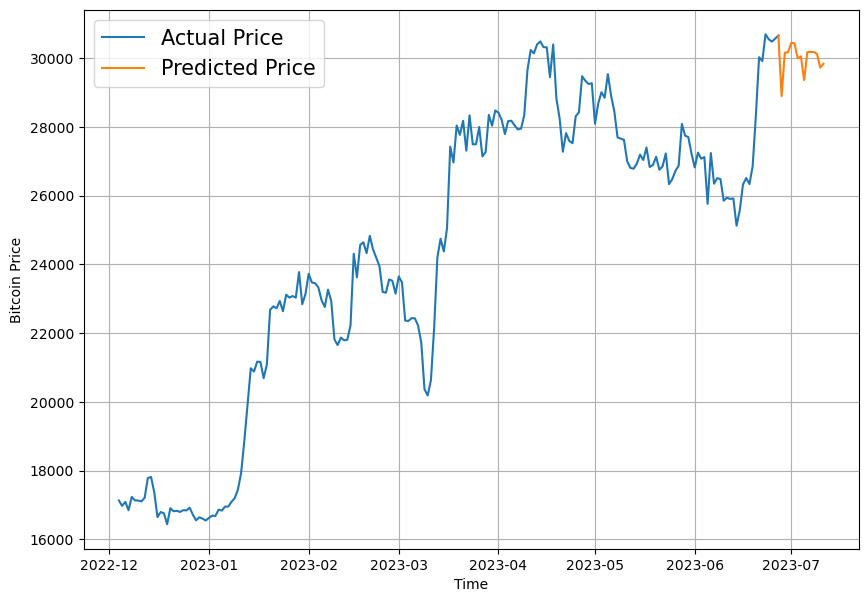

In [56]:
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, bitcoin_prices, start=3000, format="-", label="Actual Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Price")

# Conclusion

Some things are easier to forecast than others. The time of the sunrise tomorrow morning can be forecast precisely. On the other hand, tomorrow's lotto numbers cannot be forecast with any accuracy (Anyway we can see someone use Generative AI). The predictability of an event or a quantity depends on several factors including:
1. how well we understand the factors that contribute to it
2. how much data is available
3. how similar the future is to the past
4. whether the forecasts can affect the thing we are trying to forecast